In [ ]:
!pip3 -q install gudhi

     |████████████████████████████████| 28.8 MB 77.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/TDA_Esfahanian/barcode/new.zip -d ./data

In [ ]:
# !unzip -q /content/drive/MyDrive/TDA_Esfahanian/barcode/embD_2_5.zip -d ./data
!unzip -q /content/drive/MyDrive/TDA_Esfahanian/barcode/embD_6_9.zip -d ./data
# !unzip -q /content/drive/MyDrive/TDA_Esfahanian/barcode/noise_embD_2_5.zip -d ./data
!unzip -q /content/drive/MyDrive/TDA_Esfahanian/barcode/noise_embD_6_9.zip -d ./data

In [ ]:
from scipy.ndimage import gaussian_filter as gf
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from gudhi.representations import DiagramSelector

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
def betti_curve(diagram,Min='false',Max='false',n=50):
    diagram = DiagramSelector(use=True, point_type="finite")(diagram)
    if Min=='false': Min=np.min(diagram)
    if Max=='false': Max=np.max(diagram)
    br=np.linspace(Min,Max,n)
    bc=[]
    for i in br:
        bc.append(np.sum(((diagram-i)[:,0]*(diagram-i)[:,1]<0)*np.ones(len(diagram))))
    return br,np.array(bc)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TDA_Esfahanian/data_sim/df_label.csv')
df

,Unnamed: 0,mass1,mass2,total_mass,chirp_mass,mass_ratio,inclination,coa_phase,distance,f_lower,SNR
0,0,46.629051,31.006529,77.635580,32.965045,1.503846,0.524589,2.564048,1590.199495,39.933337,0.026446
1,1,26.446496,21.179368,47.625864,20.577855,1.248691,2.435221,2.623511,1440.629173,31.934164,0.017534
2,2,91.710762,38.667060,130.377822,50.911527,2.371806,2.645992,1.230911,765.507838,34.380181,0.256543
3,3,29.980681,78.335077,108.315759,41.261056,2.612852,0.758266,0.426019,2676.171883,36.255192,0.009140
4,4,10.171490,83.267300,93.438791,23.046767,8.186342,2.263270,0.857853,327.162212,36.471598,0.104722
...,...,...,...,...,...,...,...,...,...,...,...
1994,1994,40.353589,21.451593,61.805182,25.362966,1.881147,1.615627,0.178948,440.884589,39.773868,0.027972
1995,1995,9.984684,83.611383,93.596067,22.840642,8.373964,0.743929,2.150346,1674.805330,32.436613,0.005900
1996,1996,34.282154,81.307562,115.589716,45.137301,2.371717,1.654223,2.944549,1296.128637,32.601899,0.010966
1997,1997,32.727740,91.157159,123.884899,46.368218,2.785318,2.630570,2.435918,2302.301825,31.045035,0.023095


rate snr>1: 0.09204602301150576


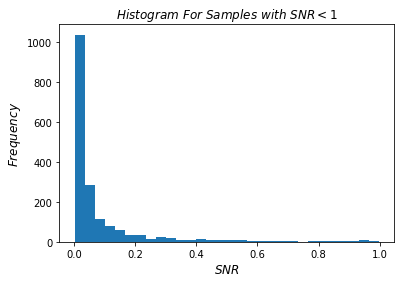

In [ ]:
snr = np.array(list(df['SNR'].values))# + list(df['SNR'].values))
th_snr_1 = (snr>1).sum()/len(snr)
print('rate snr>1:',th_snr_1)
min, max = np.percentile(snr,1),np.percentile(snr,100 - th_snr_1*100)
snr[snr<min] = min
snr = snr[snr<max]# = max
plt.hist(snr,bins=30)
plt.xlabel(r'$SNR$',size=12)
plt.ylabel(r'$Frequency$',size=12)
plt.title(r'$Histogram\ For\ Samples\ with\ SNR<1$',size=12)
plt.savefig('/content/drive/MyDrive/TDA_Esfahanian/plot_class_sample/histogram_snr.jpg',dpi=200,bbox_inches='tight');

rate snr>1: 0.09204602301150576


Text(0.5, 1.0, '$Histogram\\ For\\ Samples\\ with\\ SNR<1$')

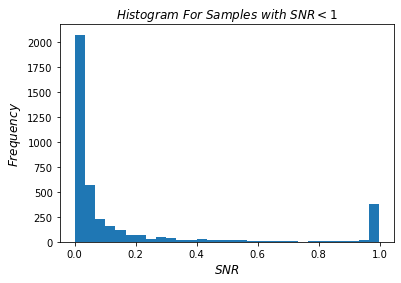

In [ ]:
snr = np.array(list(df['SNR'].values)+list(df['SNR'].values))
th_snr_1 = (snr>1).sum()/len(snr)
print('rate snr>1:',th_snr_1)
min, max = np.percentile(snr,1),np.percentile(snr,100 - th_snr_1*100)
snr[snr<min] = min
snr[snr>max] = max
plt.hist(snr,bins=30)
plt.xlabel(r'$SNR$',size=12)
plt.ylabel(r'$Frequency$',size=12)
plt.title(r'$Histogram\ For\ Samples\ with\ SNR<1$',size=12)

In [ ]:
df['SNR'].values

array([0.02644606, 0.01753417, 0.25654279, ..., 0.01096617, 0.02309453,
       0.22721549])

In [ ]:
n_th = 50
list_th = np.arange(0.004,1.002,0.004)

all_acc = []
all_mean_acc = []

for embedding_dimension_hp in [8]:
  all_acc0 = []
  for embedding_time_delay_hp in [1]:
    for stride in [1]:
      h_Number = 0
      dgms_h1 = np.load(f'data/embD={embedding_dimension_hp}_tdel={embedding_time_delay_hp}_str={stride}_dgms_h{h_Number}.npz',allow_pickle=1)['data']
      all_h1 = []
      for i in range(len(dgms_h1)):
        all_h1 += list(dgms_h1[i].flatten())
      all_h1 = np.array(all_h1).flatten()
      min_m = np.percentile(all_h1,2)
      max_m = np.percentile(all_h1,98)

      b_data = []
      for i in range(len(dgms_h1)):
        _,b = betti_curve(dgms_h1[i],Min=min_m,Max=max_m,n=n_th)
        b_data.append(b)
      b_data = np.array(b_data)

      dgms_h1 = np.load(f'data/noise_embD={embedding_dimension_hp}_tdel={embedding_time_delay_hp}_str={stride}_dgms_h{h_Number}.npz',allow_pickle=1)['data']
      b_noise = []
      for i in range(len(dgms_h1)):
        _,b = betti_curve(dgms_h1[i],Min=min_m,Max=max_m,n=n_th)
        b_noise.append(b)
      b_noise = np.array(b_noise)

      X0 = np.concatenate((b_data,b_noise),axis=0)
      X0 /= np.std(X0)
      X0 -= np.mean(X0)

    #########################################
      h_Number = 1
      dgms_h1 = np.load(f'data/embD={embedding_dimension_hp}_tdel={embedding_time_delay_hp}_str={stride}_dgms_h{h_Number}.npz',allow_pickle=1)['data']
      all_h1 = []
      for i in range(len(dgms_h1)):
        all_h1 += list(dgms_h1[i].flatten())
      all_h1 = np.array(all_h1).flatten()
      min_m = np.percentile(all_h1,2)
      max_m = np.percentile(all_h1,98)

      b_data = []
      for i in range(len(dgms_h1)):
        _,b = betti_curve(dgms_h1[i],Min=min_m,Max=max_m,n=n_th)
        b_data.append(b)
      b_data = np.array(b_data)

      dgms_h1 = np.load(f'data/noise_embD={embedding_dimension_hp}_tdel={embedding_time_delay_hp}_str={stride}_dgms_h{h_Number}.npz',allow_pickle=1)['data']
      b_noise = []
      for i in range(len(dgms_h1)):
        _,b = betti_curve(dgms_h1[i],Min=min_m,Max=max_m,n=n_th)
        b_noise.append(b)
      b_noise = np.array(b_noise)

      X1 = np.concatenate((b_data,b_noise),axis=0)
      X1 /= np.std(X1)
      X1 -= np.mean(X1)

      X_final = np.concatenate((X0,X1),axis=1)

      y = np.zeros(len(X_final))
      y[:len(b_data)] = 1

      np.random.seed(0)
      index_ra = np.arange(len(y))
      np.random.shuffle(index_ra)
      cross_val =[[index_ra[int(len(y)/5):],index_ra[:int(len(y)/5)]],
                  [index_ra[:-int(len(y)/5):],index_ra[-int(len(y)/5):]],
                  [np.concatenate((index_ra[:int(1*len(y)/5)],index_ra[int(2*len(y)/5):]),axis=0),index_ra[int(len(y)/5):int(2*len(y)/5)]],
                  [np.concatenate((index_ra[:int(2*len(y)/5)],index_ra[int(3*len(y)/5):]),axis=0),index_ra[int(2*len(y)/5):int(3*len(y)/5)]],
                  [np.concatenate((index_ra[:int(3*len(y)/5)],index_ra[int(4*len(y)/5):]),axis=0),index_ra[int(3*len(y)/5):int(4*len(y)/5)]]]

      index_snr = []
      pred = []
      y_true = []
      for c_val in range(5):
          x_train, x_test, y_train, y_test = X_final[cross_val[c_val][0]],X_final[cross_val[c_val][1]],y[cross_val[c_val][0]],y[cross_val[c_val][1]]
          index_snr += list(snr[cross_val[c_val][1]])
          clf = svm.SVC(kernel="linear", C=1.0)
          clf.fit(x_train, y_train)
          pred += list(clf.predict(x_test))
          y_true += list(y_test)
          # print(c_val,clf.score(x_test,y_test))

      y_true = np.array(y_true)
      pred = np.array(pred)

      index_snr = np.array(index_snr)
      th = []
      acc_th = []
      for i in range(0,len(list_th)):
        min_th = list_th[i]-list_th[i]/2
        max_th = list_th[i]+list_th[i]/2
        y_true_th = y_true[(index_snr>min_th)*(index_snr<max_th)]
        pred_th = pred[(index_snr>min_th)*(index_snr<max_th)]
        th.append(list_th[i])
        acc_th.append((y_true_th==pred_th).sum()/len(pred_th))
      all_acc0.append(acc_th)
      all_mean_acc.append([np.mean(acc_th),[embedding_dimension_hp,embedding_time_delay_hp,stride]])
      print(np.round(np.mean(acc_th),3),embedding_dimension_hp,embedding_time_delay_hp,stride)
  all_acc.append(all_acc0)

0.897 8 1 1


In [ ]:
embedding_time_delay_hp = 1

ls_sigma = [0,2,5,10,15,20,25,33,40,50,100]
sigma_all_acc = []
sigma_all_mean_acc = []
acc_full = []
for embedding_dimension_hp in [8]:
  all_acc0 = []
  for sigma in ls_sigma:
    for stride in [1]:
      h_Number = 0
      dgms_h1 = np.load(f'data/sigma={sigma}_embD={embedding_dimension_hp}_tdel={embedding_time_delay_hp}_str={stride}_dgms_h{h_Number}.npz',allow_pickle=1)['data']
      all_h1 = []
      for i in range(len(dgms_h1)):
        all_h1 += list(dgms_h1[i].flatten())
      all_h1 = np.array(all_h1).flatten()
      min_m = np.percentile(all_h1,2)
      max_m = np.percentile(all_h1,98)

      b_data = []
      for i in range(len(dgms_h1)):
        _,b = betti_curve(dgms_h1[i],Min=min_m,Max=max_m,n=n_th)
        b_data.append(b)
      b_data = np.array(b_data)

      dgms_h1 = np.load(f'data/sigma={sigma}_noise_embD={embedding_dimension_hp}_tdel={embedding_time_delay_hp}_str={stride}_dgms_h{h_Number}.npz',allow_pickle=1)['data']
      b_noise = []
      for i in range(len(dgms_h1)):
        _,b = betti_curve(dgms_h1[i],Min=min_m,Max=max_m,n=n_th)
        b_noise.append(b)
      b_noise = np.array(b_noise)

      X0 = np.concatenate((b_data,b_noise),axis=0)
      X0 /= np.std(X0)
      X0 -= np.mean(X0)

    #########################################
      h_Number = 1
      dgms_h1 = np.load(f'data/sigma={sigma}_embD={embedding_dimension_hp}_tdel={embedding_time_delay_hp}_str={stride}_dgms_h{h_Number}.npz',allow_pickle=1)['data']
      all_h1 = []
      for i in range(len(dgms_h1)):
        all_h1 += list(dgms_h1[i].flatten())
      all_h1 = np.array(all_h1).flatten()
      min_m = np.percentile(all_h1,2)
      max_m = np.percentile(all_h1,98)

      b_data = []
      for i in range(len(dgms_h1)):
        _,b = betti_curve(dgms_h1[i],Min=min_m,Max=max_m,n=n_th)
        b_data.append(b)
      b_data = np.array(b_data)

      dgms_h1 = np.load(f'data/sigma={sigma}_noise_embD={embedding_dimension_hp}_tdel={embedding_time_delay_hp}_str={stride}_dgms_h{h_Number}.npz',allow_pickle=1)['data']
      b_noise = []
      for i in range(len(dgms_h1)):
        _,b = betti_curve(dgms_h1[i],Min=min_m,Max=max_m,n=n_th)
        b_noise.append(b)
      b_noise = np.array(b_noise)

      X1 = np.concatenate((b_data,b_noise),axis=0)
      X1 /= np.std(X1)
      X1 -= np.mean(X1)

      X_final = np.concatenate((X0,X1),axis=1)

      y = np.zeros(len(X_final))
      y[:len(b_data)] = 1

      np.random.seed(0)
      index_ra = np.arange(len(y))
      np.random.shuffle(index_ra)
      cross_val =[[index_ra[int(len(y)/5):],index_ra[:int(len(y)/5)]],
                  [index_ra[:-int(len(y)/5):],index_ra[-int(len(y)/5):]],
                  [np.concatenate((index_ra[:int(1*len(y)/5)],index_ra[int(2*len(y)/5):]),axis=0),index_ra[int(len(y)/5):int(2*len(y)/5)]],
                  [np.concatenate((index_ra[:int(2*len(y)/5)],index_ra[int(3*len(y)/5):]),axis=0),index_ra[int(2*len(y)/5):int(3*len(y)/5)]],
                  [np.concatenate((index_ra[:int(3*len(y)/5)],index_ra[int(4*len(y)/5):]),axis=0),index_ra[int(3*len(y)/5):int(4*len(y)/5)]]]

      index_snr = []
      pred = []
      y_true = []
      acc_full0 = []
      for c_val in range(5):
          x_train, x_test, y_train, y_test = X_final[cross_val[c_val][0]],X_final[cross_val[c_val][1]],y[cross_val[c_val][0]],y[cross_val[c_val][1]]
          index_snr += list(snr[cross_val[c_val][1]])
          clf = svm.SVC(kernel="linear", C=1.0)
          clf.fit(x_train, y_train)
          pred_test = clf.predict(x_test)
          acc_full0.append((y_test==pred_test).sum()/len(pred_test))
          pred += list(pred_test)
          y_true += list(y_test)
          # print(c_val,clf.score(x_test,y_test))

      y_true = np.array(y_true)
      pred = np.array(pred)
      acc_full.append(acc_full0)
      index_snr = np.array(index_snr)
      th = []
      acc_th = []
      for i in range(0,len(list_th)):
        min_th = list_th[i]-list_th[i]/2
        max_th = list_th[i]+list_th[i]/2
        y_true_th = y_true[(index_snr>min_th)*(index_snr<max_th)]
        pred_th = pred[(index_snr>min_th)*(index_snr<max_th)]
        th.append(list_th[i])
        acc_th.append((y_true_th==pred_th).sum()/len(pred_th))
      all_acc0.append(acc_th)
      sigma_all_mean_acc.append([np.mean(acc_th),[embedding_dimension_hp,embedding_time_delay_hp,stride]])
      print(np.round(np.mean(acc_th),3),embedding_dimension_hp,embedding_time_delay_hp,stride)
  sigma_all_acc.append(all_acc0)

0.897 8 1 1
0.931 8 1 1
0.934 8 1 1
0.922 8 1 1
0.939 8 1 1
0.942 8 1 1
0.973 8 1 1
0.989 8 1 1
0.994 8 1 1
0.991 8 1 1
0.979 8 1 1


In [ ]:
sigma_all_acc = np.array(sigma_all_acc)
sigma_all_mean_acc = np.array(sigma_all_mean_acc)
acc_full = np.array(acc_full)

acc_full.shape,sigma_all_mean_acc.shape,sigma_all_acc.shape

<ipython-input-15-283350dd528a>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sigma_all_mean_acc = np.array(sigma_all_mean_acc)


((11, 5), (11, 2), (1, 11, 250))

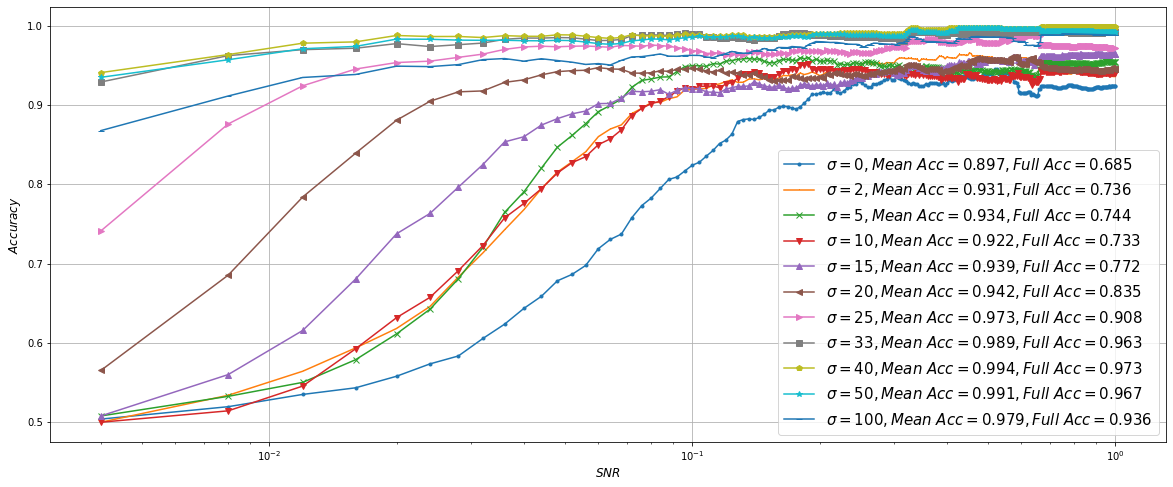

In [ ]:
marker = [".",",","x","v","^","<",">","s","p","*","_","d"]
plt.figure(figsize=(20,8))
for i in range(11):
  plt.plot(th,sigma_all_acc[0,i],marker=marker[i],label=fr'$\sigma={ls_sigma[i]},Mean\ Acc={np.round(np.mean(sigma_all_acc[0,i]),3)},Full\ Acc={np.round(np.mean(acc_full.mean(axis=1)[i]),3)}$')
  plt.xscale('log')
  plt.xlabel(r'$SNR$',size=12)
  plt.ylabel(r'$Accuracy$',size=12)
  plt.grid()
  plt.legend(fontsize=15)
  plt.savefig('/content/drive/MyDrive/TDA_Esfahanian/plot_class_sample/accuracy_curve_smoothing.jpg',dpi=200,bbox_inches='tight');

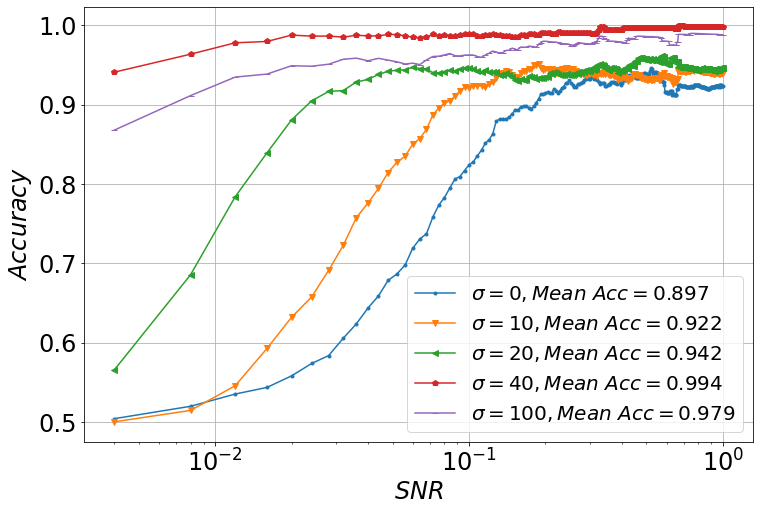

In [ ]:
marker = [".",",","x","v","^","<",">","s","p","*","_","d"]
plt.figure(figsize=(12,8))
for i in [0,3,5,8,10]:
  plt.plot(th,sigma_all_acc[0,i],marker=marker[i],label=fr'$\sigma={ls_sigma[i]},Mean\ Acc={np.round(np.mean(sigma_all_acc[0,i]),3)}$')
plt.xscale('log')
plt.xlabel(r'$SNR$',size=24)
plt.ylabel(r'$Accuracy$',size=24)
plt.grid()
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=20)
plt.savefig('/content/drive/MyDrive/TDA_Esfahanian/iran_paper/accuracy_curve_smoothing.jpg',dpi=250,bbox_inches='tight');

In [ ]:
embedding_time_delay_hp = 1

ls_fft = [0,0.1,0.2,0.3,0.4,0.5,0.65,0.8,1,1.2]
fft_all_acc = []
fft_all_mean_acc = []

for embedding_dimension_hp in [8]:
  all_acc0 = []
  for fft in ls_fft:
    for stride in [1]:
      h_Number = 0
      dgms_h1 = np.load(f'data/fft={fft}_embD={embedding_dimension_hp}_tdel={embedding_time_delay_hp}_str={stride}_dgms_h{h_Number}.npz',allow_pickle=1)['data']
      all_h1 = []
      for i in range(len(dgms_h1)):
        all_h1 += list(dgms_h1[i].flatten())
      all_h1 = np.array(all_h1).flatten()
      min_m = np.percentile(all_h1,2)
      max_m = np.percentile(all_h1,98)

      b_data = []
      for i in range(len(dgms_h1)):
        _,b = betti_curve(dgms_h1[i],Min=min_m,Max=max_m,n=n_th)
        b_data.append(b)
      b_data = np.array(b_data)

      dgms_h1 = np.load(f'data/fft={fft}_noise_embD={embedding_dimension_hp}_tdel={embedding_time_delay_hp}_str={stride}_dgms_h{h_Number}.npz',allow_pickle=1)['data']
      b_noise = []
      for i in range(len(dgms_h1)):
        _,b = betti_curve(dgms_h1[i],Min=min_m,Max=max_m,n=n_th)
        b_noise.append(b)
      b_noise = np.array(b_noise)

      X0 = np.concatenate((b_data,b_noise),axis=0)
      X0 /= np.std(X0)
      X0 -= np.mean(X0)

    #########################################
      h_Number = 1
      dgms_h1 = np.load(f'data/fft={fft}_embD={embedding_dimension_hp}_tdel={embedding_time_delay_hp}_str={stride}_dgms_h{h_Number}.npz',allow_pickle=1)['data']
      all_h1 = []
      for i in range(len(dgms_h1)):
        all_h1 += list(dgms_h1[i].flatten())
      all_h1 = np.array(all_h1).flatten()
      min_m = np.percentile(all_h1,2)
      max_m = np.percentile(all_h1,98)

      b_data = []
      for i in range(len(dgms_h1)):
        _,b = betti_curve(dgms_h1[i],Min=min_m,Max=max_m,n=n_th)
        b_data.append(b)
      b_data = np.array(b_data)

      dgms_h1 = np.load(f'data/fft={fft}_noise_embD={embedding_dimension_hp}_tdel={embedding_time_delay_hp}_str={stride}_dgms_h{h_Number}.npz',allow_pickle=1)['data']
      b_noise = []
      for i in range(len(dgms_h1)):
        _,b = betti_curve(dgms_h1[i],Min=min_m,Max=max_m,n=n_th)
        b_noise.append(b)
      b_noise = np.array(b_noise)

      X1 = np.concatenate((b_data,b_noise),axis=0)
      X1 /= np.std(X1)
      X1 -= np.mean(X1)

      X_final = np.concatenate((X0,X1),axis=1)

      y = np.zeros(len(X_final))
      y[:len(b_data)] = 1

      np.random.seed(0)
      index_ra = np.arange(len(y))
      np.random.shuffle(index_ra)
      cross_val =[[index_ra[int(len(y)/5):],index_ra[:int(len(y)/5)]],
                  [index_ra[:-int(len(y)/5):],index_ra[-int(len(y)/5):]],
                  [np.concatenate((index_ra[:int(1*len(y)/5)],index_ra[int(2*len(y)/5):]),axis=0),index_ra[int(len(y)/5):int(2*len(y)/5)]],
                  [np.concatenate((index_ra[:int(2*len(y)/5)],index_ra[int(3*len(y)/5):]),axis=0),index_ra[int(2*len(y)/5):int(3*len(y)/5)]],
                  [np.concatenate((index_ra[:int(3*len(y)/5)],index_ra[int(4*len(y)/5):]),axis=0),index_ra[int(3*len(y)/5):int(4*len(y)/5)]]]

      index_snr = []
      pred = []
      y_true = []
      for c_val in range(5):
          x_train, x_test, y_train, y_test = X_final[cross_val[c_val][0]],X_final[cross_val[c_val][1]],y[cross_val[c_val][0]],y[cross_val[c_val][1]]
          index_snr += list(snr[cross_val[c_val][1]])
          clf = svm.SVC(kernel="linear", C=1.0)
          clf.fit(x_train, y_train)
          pred += list(clf.predict(x_test))
          y_true += list(y_test)
          # print(c_val,clf.score(x_test,y_test))

      y_true = np.array(y_true)
      pred = np.array(pred)

      index_snr = np.array(index_snr)
      th = []
      acc_th = []
      for i in range(0,len(list_th)):
        min_th = list_th[i]-list_th[i]/2
        max_th = list_th[i]+list_th[i]/2
        y_true_th = y_true[(index_snr>min_th)*(index_snr<max_th)]
        pred_th = pred[(index_snr>min_th)*(index_snr<max_th)]
        th.append(list_th[i])
        acc_th.append((y_true_th==pred_th).sum()/len(pred_th))
      all_acc0.append(acc_th)
      fft_all_mean_acc.append([np.mean(acc_th),[embedding_dimension_hp,embedding_time_delay_hp,stride]])
      print(np.round(np.mean(acc_th),3),embedding_dimension_hp,embedding_time_delay_hp,stride)
  fft_all_acc.append(all_acc0)

0.897 8 1 1
0.889 8 1 1
0.875 8 1 1
0.88 8 1 1
0.886 8 1 1
0.879 8 1 1
0.874 8 1 1
0.811 8 1 1
0.812 8 1 1
0.858 8 1 1


In [ ]:
all_acc = np.array(all_acc)
sigma_all_acc = np.array(sigma_all_acc)
fft_all_acc = np.array(fft_all_acc)
sigma_all_acc.shape,fft_all_acc.shape

(1, 11, 499)

In [ ]:
# np.save('/content/drive/MyDrive/TDA_Esfahanian/all_acc.npy',all_acc)

In [ ]:
# all_acc = np.load('/content/drive/MyDrive/TDA_Esfahanian/all_acc.npy')
# th = np.arange(0.004,1.002,0.002)

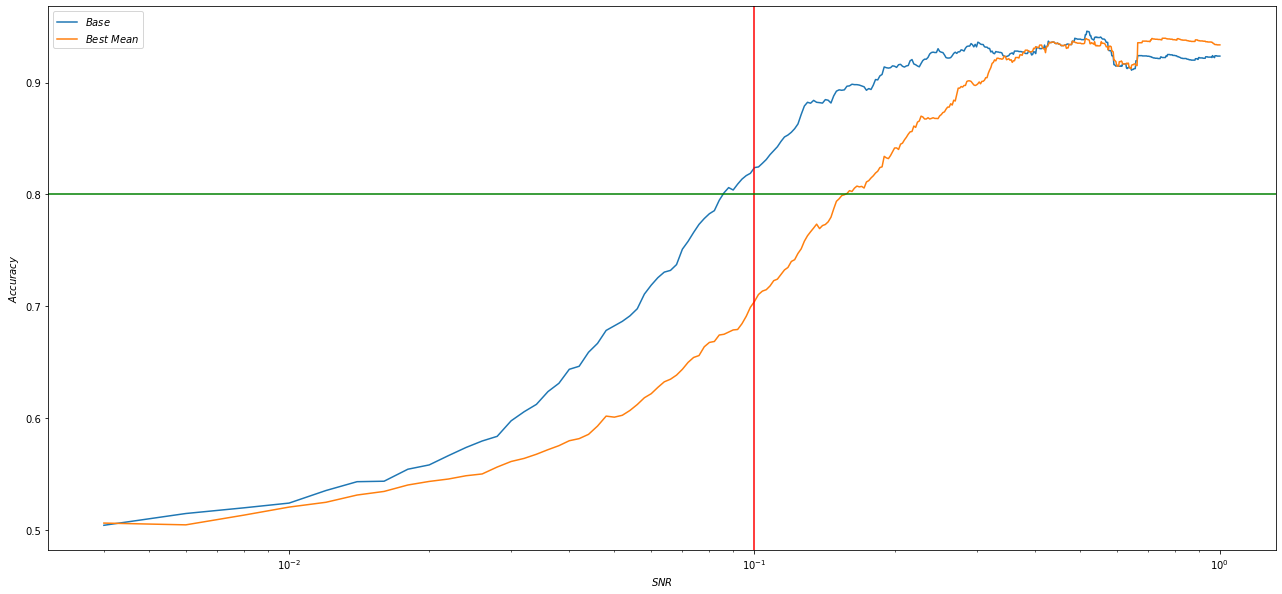

In [ ]:
plt.figure(figsize=(22,10))
plt.plot(th,all_acc[0,0],label=r'$Base$')
plt.plot(th,sigma_all_acc[0,5],label=r'$Best\ Mean$')
# plt.scatter(th,acc_th)
plt.xscale('log')
plt.axvline(0.1,color='red')
plt.axhline(0.8,color='green')
plt.xlabel(r'$SNR$')
plt.ylabel(r'$Accuracy$')
plt.legend();

In [ ]:


X_final = np.concatenate((X0,X1),axis=1)

y = np.zeros(len(X_final))
y[:len(b_data)] = 1

np.random.seed(0)
index_ra = np.arange(len(y))
np.random.shuffle(index_ra)
cross_val =[[index_ra[int(len(y)/5):],index_ra[:int(len(y)/5)]],
            [index_ra[:-int(len(y)/5):],index_ra[-int(len(y)/5):]],
            [np.concatenate((index_ra[:int(1*len(y)/5)],index_ra[int(2*len(y)/5):]),axis=0),index_ra[int(len(y)/5):int(2*len(y)/5)]],
            [np.concatenate((index_ra[:int(2*len(y)/5)],index_ra[int(3*len(y)/5):]),axis=0),index_ra[int(2*len(y)/5):int(3*len(y)/5)]],
            [np.concatenate((index_ra[:int(3*len(y)/5)],index_ra[int(4*len(y)/5):]),axis=0),index_ra[int(3*len(y)/5):int(4*len(y)/5)]]]

index_snr = []
pred = []
y_true = []
for c_val in range(5):
    x_train, x_test, y_train, y_test = X_final[cross_val[c_val][0]],X_final[cross_val[c_val][1]],y[cross_val[c_val][0]],y[cross_val[c_val][1]]
    index_snr += list(snr[cross_val[c_val][1]])
    clf = svm.SVC(kernel="linear", C=1.0)
    clf.fit(x_train, y_train)
    pred += list(clf.predict(x_test))
    y_true += list(y_test)
    # print(c_val,clf.score(x_test,y_test))

y_true = np.array(y_true)
pred = np.array(pred)